In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import seaborn as sns




In [7]:
def prepare_fire_data(file_path):
    # Load and parse dates
    df = pd.read_csv(file_path)

    # Convert to timezone-naive datetime
    df['ALARM_DATE'] = pd.to_datetime(df['ALARM_DATE']).dt.tz_localize(None)
    df['CONT_DATE'] = pd.to_datetime(df['CONT_DATE']).dt.tz_localize(None)

    # Create daily time series
    daily_fires = df.groupby(pd.Grouper(key='ALARM_DATE', freq='D')).agg(
        fire_count=('INC_NUM', 'count'),
        total_acres=('GIS_ACRES', 'sum')
    ).reset_index()

    # Rename columns
    daily_fires.columns = ['ds', 'y_fire_count', 'y_acres_burned']

    # Fill missing dates with zeros
    date_range = pd.date_range(
        start=daily_fires['ds'].min(),
        end=daily_fires['ds'].max(),
        tz=None  # Ensure timezone-naive
    )

    daily_fires = daily_fires.set_index('ds').reindex(date_range).fillna(0).reset_index()
    daily_fires.columns = ['ds', 'y_fire_count', 'y_acres_burned']

    return daily_fires


In [8]:

fire_data = prepare_fire_data('California_Fire_Perimeters_(1950%2B).csv')

# Time Series Split (80/20)
split_date = fire_data['ds'].quantile(0.8)
train = fire_data[fire_data.ds <= split_date]
test = fire_data[fire_data.ds > split_date]


In [9]:
def run_prophet_forecast(train_data, test_data, target_col='y_fire_count'):
    # Initialize model with optimized parameters
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,  # Disabled weekly pattern for fires
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        seasonality_mode='multiplicative'
    )

    # Prepare data
    prophet_train = train_data[['ds', target_col]].rename(columns={target_col: 'y'})

    # Fit model
    model.fit(prophet_train)

    # Create future dates matching test period
    future = test_data[['ds']].copy()

    # Generate forecast
    forecast = model.predict(future)

    # Merge actual values
    results = pd.merge(forecast, test_data[['ds', target_col]], on='ds')
    results = results[['ds', 'yhat', target_col]]
    results.columns = ['date', 'predicted', 'actual']

    return model, results


In [10]:
# For Fire Count
model_fc, results_fc = run_prophet_forecast(train, test, 'y_fire_count')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpx4142fwx/p8vtk1z8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx4142fwx/u0a4fxrc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28148', 'data', 'file=/tmp/tmpx4142fwx/p8vtk1z8.json', 'init=/tmp/tmpx4142fwx/u0a4fxrc.json', 'output', 'file=/tmp/tmpx4142fwx/prophet_modelz9sbclvl/prophet_model-20250225113005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [11]:
# For Acres Burned
model_acres, results_acres = run_prophet_forecast(train, test, 'y_acres_burned')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpx4142fwx/topfyz_o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx4142fwx/iyqppjr0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85406', 'data', 'file=/tmp/tmpx4142fwx/topfyz_o.json', 'init=/tmp/tmpx4142fwx/iyqppjr0.json', 'output', 'file=/tmp/tmpx4142fwx/prophet_modelfh_je0aa/prophet_model-20250225113030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [12]:
# Evaluation Metrics
def evaluate_model(results, target_name):
    print(f'\nEvaluation for {target_name}:')
    mae = mean_absolute_error(results.actual, results.predicted)
    rmse = sqrt(mean_squared_error(results.actual, results.predicted))
    print(f'MAE: {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')

    # Calculate accuracy for non-zero values
    non_zero = results[results.actual > 0]
    if len(non_zero) > 0:
        mape = np.mean(np.abs((non_zero.actual - non_zero.predicted) / non_zero.actual)) * 100
        print(f'MAPE (non-zero days): {mape:.2f}%')


In [13]:
evaluate_model(results_fc, 'Fire Count')
evaluate_model(results_acres, 'Acres Burned')



Evaluation for Fire Count:
MAE: 0.72
RMSE: 1.91
MAPE (non-zero days): 61.65%

Evaluation for Acres Burned:
MAE: 3077.37
RMSE: 27620.39
MAPE (non-zero days): 85900.99%


In [14]:
# Time Series Cross-Validation
def perform_cv(model, train_data, horizon=365):
    df_cv = cross_validation(
        model,
        initial='3650 days',  # 10-year training
        period='180 days',    # 6-month spacing
        horizon=f'{horizon} days',
        parallel="processes"
    )
    df_p = performance_metrics(df_cv)
    return df_cv, df_p


In [15]:
# Cross-validate fire count model
cv_fc, perf_fc = perform_cv(model_fc, train)


INFO:prophet:Making 182 forecasts with cutoffs between 1908-08-18 00:00:00 and 1997-10-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7dc53f736250>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx4142fwx/sy1dkyru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx4142fwx/rfqo6tps.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx4142fwx/q_sc3fmd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10631', 'data', 'file=/tmp/tmpx4142fwx/sy1dkyru.json', 'init=/tmp/tmpx4142fwx/q_sc3fmd.json', 'output', 'file=/tmp/tmpx4142fwx/prophet_model7jvbmcmo/prophet_model-20250225113245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:32:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx4142fwx/s2ifw1hc.json
D

In [16]:
#  Visualization
def plot_results(results, title):
    plt.figure(figsize=(12, 6))
    plt.plot(results.date, results.actual, label='Actual', alpha=0.7)
    plt.plot(results.date, results.predicted, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


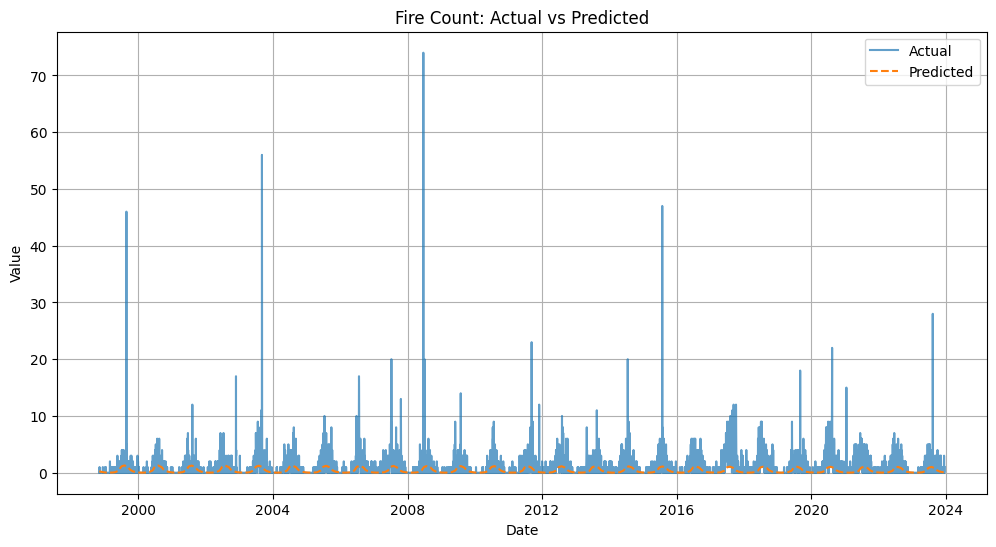

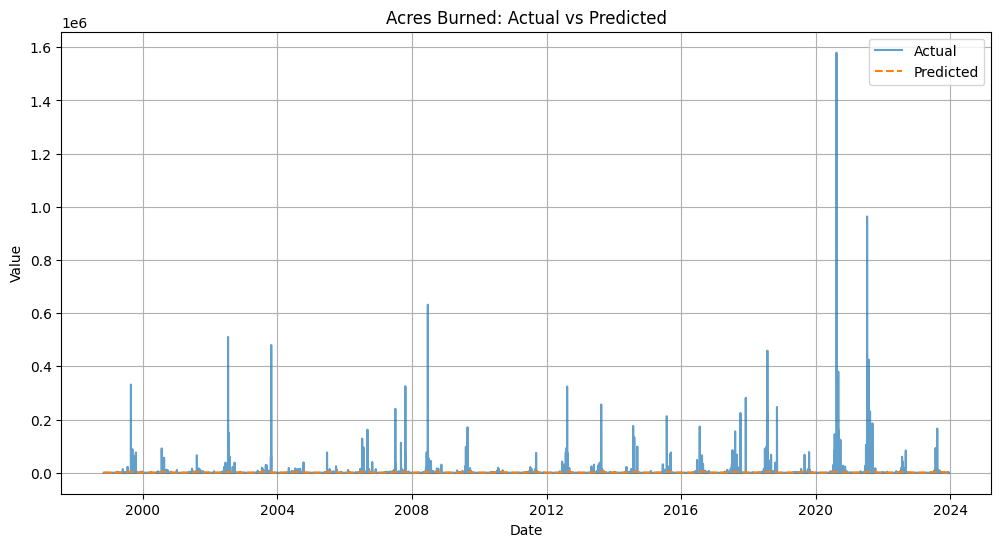

In [17]:
plot_results(results_fc, 'Fire Count: Actual vs Predicted')
plot_results(results_acres, 'Acres Burned: Actual vs Predicted')
